# Recruitment Data Challenge

The Bioinformatics & Biostatistics Group @ The Francis Crick Institute

## Introduction

Here you will find the data from an RNA-Seq and ATAC-Seq experiment. Both experiments have the same design. There is a treatment and control group each containing three replicates making a total of six samples per experiment. The data files are defined as follows (all files are tab delimited text files):

#### RNA-Seq Data

- **rnaseq_design.txt**: Sample ids and corresponding condition labels.
- **rnaseq_gene_counts.txt**: Raw (not normalised) gene-level read counts for each sample.
- **rnaseq_annotation.txt**: Gene level annotation.

#### ATAC-Seq Data

- **atacseq_design.txt**: Sample ids and corresponding condition labels.
- **atacseq_peak_counts.txt**: Raw (not normalised) ATAC-Seq peak level counts for each sample.
- **atacseq_peaks.bed**: A bed file defining the peak loci

All sequence data were aligned to the human genome reference hg38.

## The Challenge

The treatment here is thought to activate a transcriptional program via remodelling of the chromatin architecture. The aim here is to:  
1. Identify genes that may be regulated in this fashion.  
2. Identify the possible transcriptional programs involved.  
3. Present candidate transcription factors that may be responsible for the underlying regulation.  

Please produce a 20 minute presentation detailing your exploration of the data, your analysis approach and findings?


# Analysis
## Strategy

1. Identify genes with significant changes in expression.
2. Identify zones with significant changes in accessibility.
3. Detect hotspots in accessibility changes over gene regulatory areas of differentially expressed genes.
4. Detect enriched TF motifs in zones presenting accessibility changes.
5. Detect enriched TF motifs in hotspots.
6. Perform GO Analysis to put genes in context.

## Differential Expression with DESeq2
### Setup

In [1]:
library("DESeq2")
library("IHW")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: 'S4Vectors'


The

import data

In [2]:
#atac_cts <- as.matrix(read.csv("data_challenge/atacseq_peak_counts.txt",sep="\t",row.names="peakid"))
atac_fcts <- as.matrix(read.csv("output/atacseq_fpeak_counts.txt",
                                sep="\t",
                                row.names="peakid"))
atac_col <- read.csv("data_challenge/atacseq_design.txt",
                     sep="\t",
                     row.names="sample.id")
dim(atac_fcts)
head(atac_fcts,2)
atac_col

[1] 173264      6

,s84,s85,s86,s93,s94,s95
1:10003-10507,278,195,292,255,287,284
1:20221-22634,66,56,90,67,66,120


,condition
,<fct>
s84,control
s85,control
s86,control
s93,treated
s94,treated
s95,treated


In [3]:
rna_cts <- as.matrix(read.csv("data_challenge/rnaseq_gene_counts.txt",
                              sep="\t",
                              row.names="featureid"))
rna_col <- read.csv("data_challenge/rnaseq_design.txt",
                    sep="\t",
                    row.names="sample.id")
dim(rna_cts)
head(rna_cts,2)
rna_col

[1] 58051     6

,s69,s70,s71,s75,s76,s77
ENSG00000000003,1,1,0,8,2,1
ENSG00000000005,0,0,0,0,0,0


,condition
,<fct>
s69,control
s70,control
s71,control
s75,treated
s76,treated
s77,treated


Double check for entry into DESeq2

In [4]:
all(rownames(atac_col) == colnames(atac_fcts))
all(rownames(rna_col) == colnames(rna_cts))

[1] TRUE

[1] TRUE

In [5]:
atac_DDS <- DESeqDataSetFromMatrix(countData = atac_fcts, 
                                   colData = atac_col, 
                                   design = ~ condition)
atac_DDS

class: DESeqDataSet 
dim: 173264 6 
metadata(1): version
assays(1): counts
rownames(173264): 1:10003-10507 1:20221-22634 ... Y:56850334-56851158
  Y:56864434-56864700
rowData names(0):
colnames(6): s84 s85 ... s94 s95
colData names(1): condition

In [6]:
rna_DDS <- DESeqDataSetFromMatrix(countData = rna_cts, 
                                  colData = rna_col, 
                                  design = ~ condition)
rna_DDS

class: DESeqDataSet 
dim: 58051 6 
metadata(1): version
assays(1): counts
rownames(58051): ENSG00000000003 ENSG00000000005 ... ENSG00000283698
  ENSG00000283699
rowData names(0):
colnames(6): s69 s70 ... s76 s77
colData names(1): condition

Set reference

In [7]:
atac_DDS$condition <- relevel(atac_DDS$condition, 
                              ref = "control")
rna_DDS$condition <- relevel(rna_DDS$condition, 
                             ref = "control")

### rLog normalisation and PCA

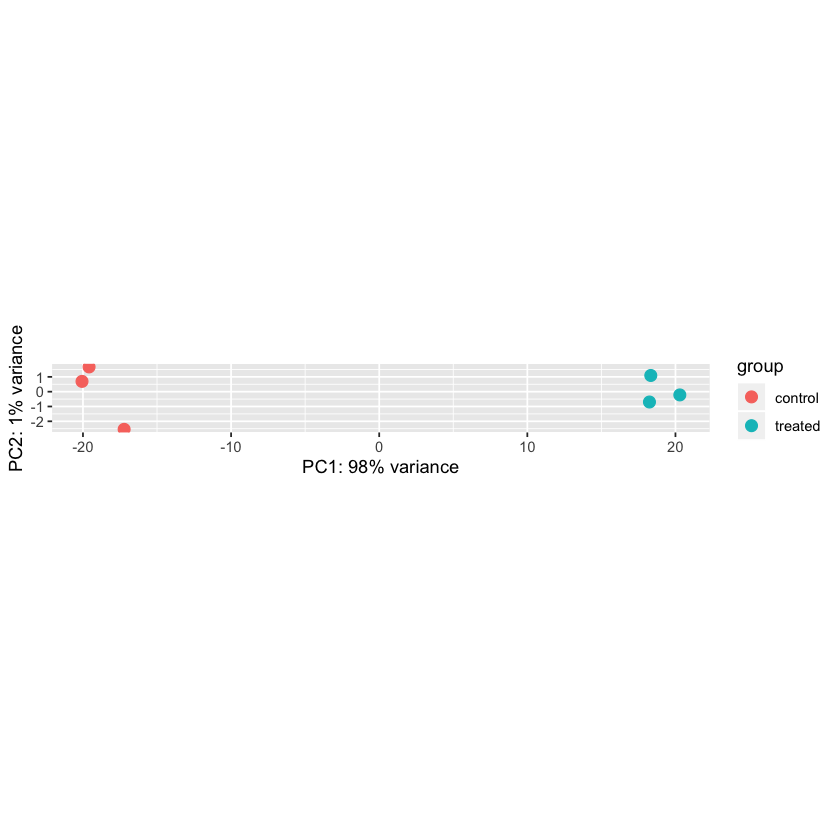

pdf 
  2

pdf 
  2

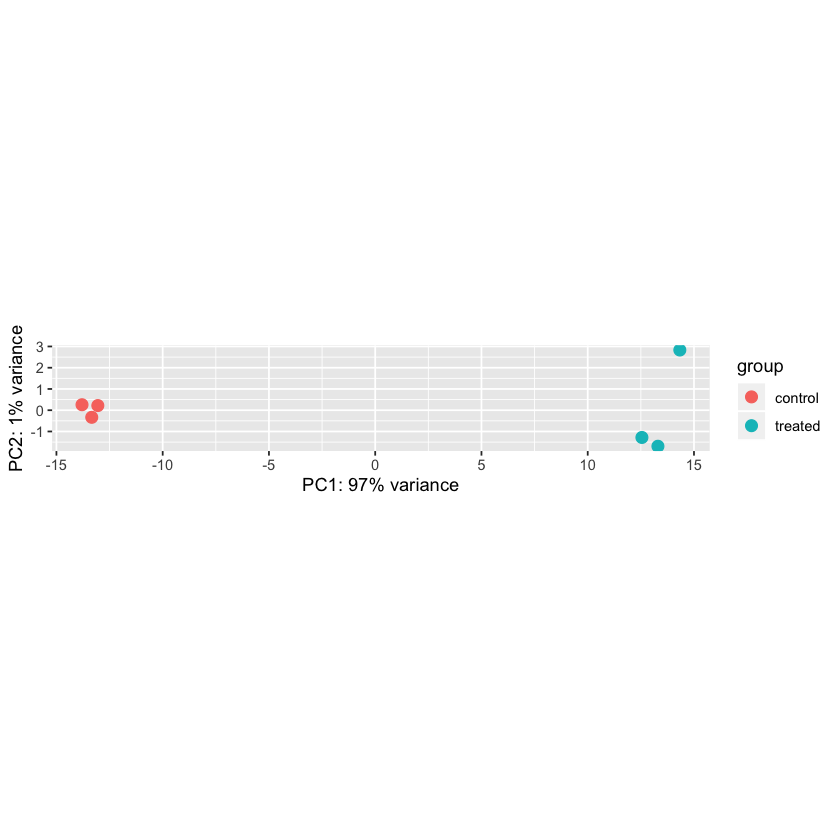

In [8]:
atac_DDS_Rlog <- rlog(atac_DDS)
rna_DDS_Rlog <- rlog(rna_DDS)
par(mfrow=c(1,2))
plotPCA(atac_DDS_Rlog, intgroup = "condition")
plotPCA(rna_DDS_Rlog, intgroup = "condition")
png("output/plot/atac_pca.png", width = 800, height = 800)
plotPCA(atac_DDS_Rlog, intgroup = "condition")
dev.off()
png("output/plot/rna_pca.png", width = 800, height = 800)
plotPCA(rna_DDS_Rlog, intgroup = "condition")
dev.off()

### DESeq2 Analysis

In [9]:
atac_DDS_dea <- DESeq(atac_DDS)
rna_DDS_dea <- DESeq(rna_DDS)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Quick look at results with Benjamini-Hochberg (BH) FDR < 0.05

In [10]:
atac_DDS_dea_res <- results(atac_DDS_dea)
summary(atac_DDS_dea_res)
sum(atac_DDS_dea_res$padj < 0.05, na.rm = TRUE)


out of 173264 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 21543, 12%
LFC < 0 (down)     : 16786, 9.7%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 29556

In [11]:
rna_DDS_dea_res <- results(rna_DDS_dea)
summary(rna_DDS_dea_res)
sum(rna_DDS_dea_res$padj < 0.05, na.rm = TRUE)


out of 28704 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3587, 12%
LFC < 0 (down)     : 3327, 12%
outliers [1]       : 1, 0.0035%
low counts [2]     : 10531, 37%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] 6073

Quick look at results with Independent Hypothesis Weighting (IHW) FDR < 0.05

In [12]:
atac_DDS_dea_resIHW <- results(atac_DDS_dea, filterFun=ihw)
summary(atac_DDS_dea_resIHW)
sum(atac_DDS_dea_resIHW$padj < 0.05, na.rm = TRUE)


out of 173264 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 22782, 13%
LFC < 0 (down)     : 16128, 9.3%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



[1] 29636

In [13]:
rna_DDS_dea_resIHW <- results(rna_DDS_dea, filterFun=ihw)
summary(rna_DDS_dea_resIHW)
sum(rna_DDS_dea_resIHW$padj < 0.05, na.rm = TRUE)


out of 28704 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3586, 12%
LFC < 0 (down)     : 3388, 12%
outliers [1]       : 1, 0.0035%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



[1] 6154

### Plotting

Shrinkage

In [14]:
#check the coef term
resultsNames(atac_DDS_dea)
resultsNames(rna_DDS_dea)

[1] "Intercept"                    "condition_treated_vs_control"

[1] "Intercept"                    "condition_treated_vs_control"

In [15]:
atac_DDS_dea_resLFC <- lfcShrink(atac_DDS_dea, coef = "condition_treated_vs_control", type = "apeglm")
rna_DDS_dea_resLFC <- lfcShrink(rna_DDS_dea, coef = "condition_treated_vs_control", type = "apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



Scatter plots

pdf 
  2

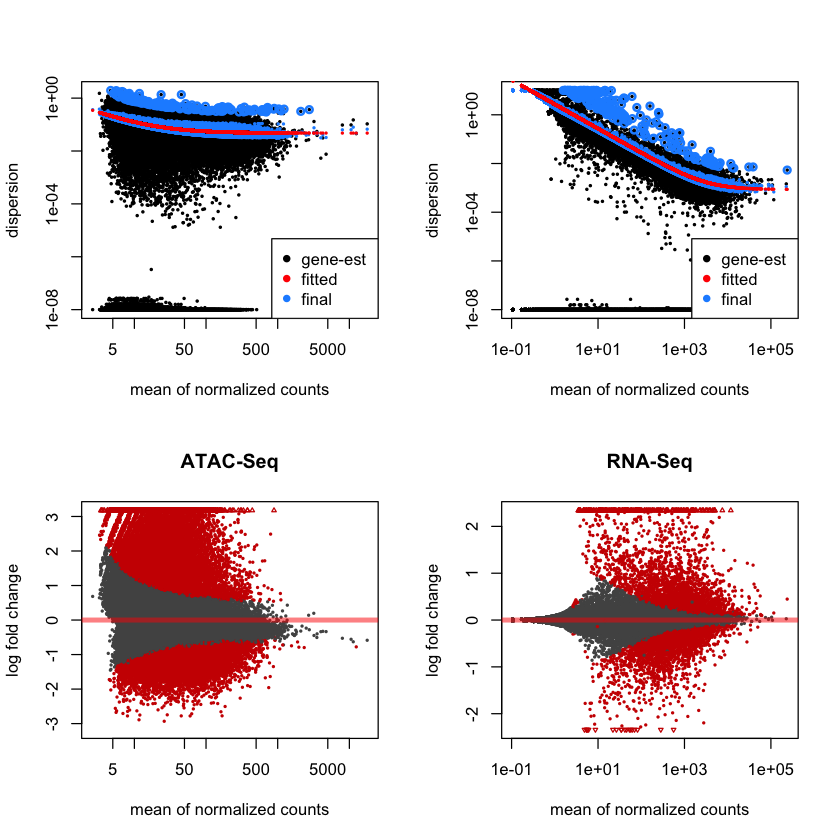

In [16]:
par(mfrow=c(2,2))
plotDispEsts(atac_DDS_dea)
plotDispEsts(rna_DDS_dea)
plotMA(atac_DDS_dea_resLFC, main = "ATAC-Seq", alpha = 0.05)
plotMA(rna_DDS_dea_resLFC, main = "RNA-Seq", alpha = 0.05)
#export as png
png("output/plot/diffx.png", width = 1600, height = 1600)
par(mfrow=c(2,2))
plotDispEsts(atac_DDS_dea)
plotDispEsts(rna_DDS_dea)
plotMA(atac_DDS_dea_resLFC, main = "ATAC-Seq", alpha = 0.05)
plotMA(rna_DDS_dea_resLFC, main = "RNA-Seq", alpha = 0.05)
dev.off()

### Merge and export results

Intersect genes significantly differentially expressed in both tests (BH & IHW)

In [17]:
#atacseq
atac_DDF_BH <- as.data.frame(subset(atac_DDS_dea_res, padj < 0.05))
atac_DDF_IHW <- as.data.frame(subset(atac_DDS_dea_resIHW, padj < 0.05))
atac_DDF_FDR <- merge(atac_DDF_BH, atac_DDF_IHW, by=0)
#rnaseq
rna_DDF_BH <- as.data.frame(subset(rna_DDS_dea_res, padj < 0.05))
rna_DDF_IHW <- as.data.frame(subset(rna_DDS_dea_resIHW, padj < 0.05))
rna_DDF_FDR <- merge(rna_DDF_BH, rna_DDF_IHW, by=0)
head(atac_DDF_FDR,2)
dim(atac_DDF_FDR)
head(rna_DDF_FDR,2)
dim(rna_DDF_FDR)

Row.names,baseMean.x,log2FoldChange.x,lfcSE.x,stat.x,pvalue.x,padj.x,baseMean.y,log2FoldChange.y,lfcSE.y,stat.y,pvalue.y,padj.y,weight
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1:10003-10507,272.09433,-0.842736,0.2584011,-3.261348,0.001108837,0.01045958,272.09433,-0.842736,0.2584011,-3.261348,0.001108837,0.0165143,0.5649321
1:100046749-100047203,15.93489,1.460924,0.5002989,2.920102,0.003499171,0.02561063,15.93489,1.460924,0.5002989,2.920102,0.003499171,0.0279062,0.8940267


[1] 28589    14

Row.names,baseMean.x,log2FoldChange.x,lfcSE.x,stat.x,pvalue.x,padj.x,baseMean.y,log2FoldChange.y,lfcSE.y,stat.y,pvalue.y,padj.y,weight
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000457,314.40428,0.4596662,0.1236178,3.718446,2.004525e-04,0.0009778854,314.40428,0.4596662,0.1236178,3.718446,2.004525e-04,7.594431e-04,2.048692
ENSG00000000938,32.65741,1.9510985,0.4074590,4.788454,1.680711e-06,0.0000117514,32.65741,1.9510985,0.4074590,4.788454,1.680711e-06,9.182598e-06,2.033117


[1] 5992   14

In [18]:
#removing redundant columns
atac_DDF_FDR <- atac_DDF_FDR[-c(4:5,8:12)]
rna_DDF_FDR <- rna_DDF_FDR[-c(4:5,8:12)]
head(atac_DDF_FDR,2)
head(rna_DDF_FDR,2)

Row.names,baseMean.x,log2FoldChange.x,pvalue.x,padj.x,padj.y,weight
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1:10003-10507,272.09433,-0.842736,0.001108837,0.01045958,0.0165143,0.5649321
1:100046749-100047203,15.93489,1.460924,0.003499171,0.02561063,0.0279062,0.8940267


Row.names,baseMean.x,log2FoldChange.x,pvalue.x,padj.x,padj.y,weight
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000457,314.40428,0.4596662,2.004525e-04,0.0009778854,7.594431e-04,2.048692
ENSG00000000938,32.65741,1.9510985,1.680711e-06,0.0000117514,9.182598e-06,2.033117


Merging RNA DiffX Results

In [19]:
#merge with coordinates keeping only significant diffx
rna_bed <- read.csv("output/rnaseq_genes.bed6",
                    sep="\t",
                    header = FALSE, 
                    col.names = c("chr","fstart","fend","name","score","strand"))
rna_diffx <- merge(rna_bed, 
                   rna_DDF_FDR, 
                   by.x = "name", 
                   by.y = "Row.names", 
                   all = FALSE)
rna_diffx <- rna_diffx[c(2:4,1,8,6)] #back to bed6 format
head(rna_bed,2)
head(rna_diffx,2)
write.table(rna_diffx, file="output/rna_diffx.bed", 
            sep = "\t", 
            col.names = FALSE, 
            row.names = FALSE, 
            quote = FALSE)

chr,fstart,fend,name,score,strand
<fct>,<int>,<int>,<fct>,<int>,<fct>
X,100628669,100636806,ENSG00000000003,8137,-
X,100584801,100599885,ENSG00000000005,15084,+


chr,fstart,fend,name,log2FoldChange.x,strand
<fct>,<int>,<int>,<fct>,<dbl>,<fct>
1,169853073,169888888,ENSG00000000457,0.4596662,-
1,27612668,27626569,ENSG00000000938,1.9510985,-


Merging ATAC DiffA Results

In [20]:
#merge with coordinates keeping only significant diffx
atac_bed <- read.csv("output/atacseq_fpeaks.bed6",sep="\t",header = FALSE, col.names = c("chr","fstart","fend","name","score","strand"))
atac_diffx <- merge(atac_bed, 
                    atac_DDF_FDR, 
                    by.x = "name", 
                    by.y = "Row.names", 
                    all.x = FALSE)
atac_diffx <- atac_diffx[c(2:4,1,8,6)] #back to bed6 format
dim(atac_bed)
head(atac_bed,2)
dim(atac_diffx)
head(atac_diffx,2)
write.table(atac_diffx, file="output/atac_diffx.bed", 
            sep = "\t", 
            col.names = FALSE, 
            row.names = FALSE, 
            quote = FALSE)

[1] 173264      6

chr,fstart,fend,name,score,strand
<fct>,<int>,<int>,<fct>,<int>,<fct>
1,10002,10507,1:10003-10507,505,.
1,20220,22634,1:20221-22634,2414,.


[1] 28589     6

chr,fstart,fend,name,log2FoldChange.x,strand
<fct>,<int>,<int>,<fct>,<dbl>,<fct>
1,10002,10507,1:10003-10507,-0.842736,.
1,100046748,100047203,1:100046749-100047203,1.460924,.


In [21]:
#split and export
atac_hi <- atac_diffx[atac_diffx$log2FoldChange.x > 0,]
write.table(atac_hi, 
            file="output/atac_hi.bed", 
            sep = "\t", 
            col.names = FALSE, 
            row.names = FALSE, 
            quote = FALSE)
atac_lo <- atac_diffx[atac_diffx$log2FoldChange.x < 0,]
write.table(atac_lo, 
            file="output/atac_lo.bed", 
            sep = "\t", 
            col.names = FALSE, 
            row.names = FALSE, 
            quote = FALSE)
rna_up <- rna_diffx[rna_diffx$log2FoldChange.x > 0,]
write.table(rna_up, 
            file="output/rna_up.bed", 
            sep = "\t", 
            col.names = FALSE, 
            row.names = FALSE, 
            quote = FALSE)
rna_dw <- rna_diffx[rna_diffx$log2FoldChange.x < 0,]
write.table(rna_dw, 
            file="output/rna_dw.bed", 
            sep = "\t", 
            col.names = FALSE, 
            row.names = FALSE, 
            quote = FALSE)

Cleaning Up

In [22]:
#don't need these anymore
detach("package:IHW", unload=TRUE)
detach("package:DESeq2", unload=TRUE)

In [23]:
sort(sapply(ls(),function(x){object.size(get(x))}))

atac_col             rna_col         rna_DDF_FDR          rna_DDF_BH 
               1656                1656              720776              730096 
        rna_DDF_IHW        atac_DDF_FDR         atac_DDF_BH        atac_DDF_IHW 
             789184             3887888             4018872             4267072 
             rna_dw              rna_up           rna_diffx             rna_DDS 
            4276608             4286144             4353264             4438032 
            rna_cts             rna_bed     rna_DDS_dea_res        rna_DDS_Rlog 
            5573768             5578712             6979000             7458064 
 rna_DDS_dea_resIHW         rna_DDS_dea  rna_DDS_dea_resLFC             atac_lo 
           10231120            13973632            14876368            15615984 
            atac_hi            atac_DDS          atac_diffx           atac_fcts 
           15787304            15952552            16044728            19392552 
           atac_bed    atac_DDS_dea_res       atac_DDS_Rlog atac_DDS_dea_resIHW 
           19402528            23562880            24963656            33269152 
atac_DDS_dea_resLFC        atac_DDS_dea 
           52645888            58923520

## ChIPseeker Analysis / Hotspot Identification

In [24]:
#load libraries
library(biomaRt)
library(GenomicFeatures)
library(ChIPseeker)
library(ggplot2)

Loading required package: AnnotationDbi



Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

ChIPseeker v1.20.0  For help: https://guangchuangyu.github.io/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383



Grabbing transcript level info via Biomart

In [25]:
listMarts(host="www.ensembl.org")

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 98
ENSEMBL_MART_MOUSE,Mouse strains 98
ENSEMBL_MART_SNP,Ensembl Variation 98
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 98


In [26]:
ensembl <- useMart("ENSEMBL_MART_ENSEMBL")
searchDatasets(mart = ensembl, pattern = "GRCh38")

,dataset,description,version
,<I<chr>>,<I<chr>>,<I<chr>>
85,hsapiens_gene_ensembl,Human genes (GRCh38.p13),GRCh38.p13


In [27]:
ensemblHs38 = useEnsembl(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
gene2transcript <- getBM(mart = ensemblHs38, attributes = c("ensembl_gene_id","ensembl_transcript_id"))
head(gene2transcript)
dim(gene2transcript)

ensembl_gene_id,ensembl_transcript_id
<chr>,<chr>
ENSG00000210049,ENST00000387314
ENSG00000211459,ENST00000389680
ENSG00000210077,ENST00000387342
ENSG00000210082,ENST00000387347
ENSG00000209082,ENST00000386347
ENSG00000198888,ENST00000361390


[1] 249158      2

We can generate custom TxDb objects for up/down regulated genes

In [28]:
rna_up_tids <- merge(rna_up, gene2transcript, by.x = "name", by.y = "ensembl_gene_id", all.x = TRUE)
rna_up_tids <- na.omit(rna_up_tids[,"ensembl_transcript_id"])
head(rna_up_tids)

[1] "ENST00000367771" "ENST00000423670" "ENST00000367772" "ENST00000367770"
[5] "ENST00000470238" "ENST00000457296"

In [29]:
rna_dw_tids <- merge(rna_dw, gene2transcript, by.x = "name", by.y = "ensembl_gene_id", all.x = TRUE)
rna_dw_tids <- na.omit(rna_dw_tids[,"ensembl_transcript_id"])
head(rna_dw_tids)

[1] "ENST00000483528" "ENST00000374409" "ENST00000483261" "ENST00000003583"
[5] "ENST00000475760" "ENST00000492753"

In [30]:
#this may take a while...
txdb_up <- makeTxDbFromBiomart(biomart = "ensembl", dataset="hsapiens_gene_ensembl", transcript_ids=rna_up_tids)
txdb_dw <- makeTxDbFromBiomart(biomart = "ensembl", dataset="hsapiens_gene_ensembl", transcript_ids=rna_dw_tids)

Download and preprocess the 'transcripts' data frame ... 
OK

Download and preprocess the 'chrominfo' data frame ... 
OK

Download and preprocess the 'splicings' data frame ... 
OK

Download and preprocess the 'genes' data frame ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK

Download and preprocess the 'transcripts' data frame ... 
OK

Download and preprocess the 'chrominfo' data frame ... 
OK

Download and preprocess the 'splicings' data frame ... 
OK

Download and preprocess the 'genes' data frame ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



Import the data

In [31]:
atac_hi_GR <- readPeakFile("output/atac_hi.bed", as = "GRanges")
atac_lo_GR <- readPeakFile("output/atac_lo.bed", as = "GRanges")

GL000216.2 dosen't contain signal higher than 1

KI270711.1 dosen't contain signal higher than 1



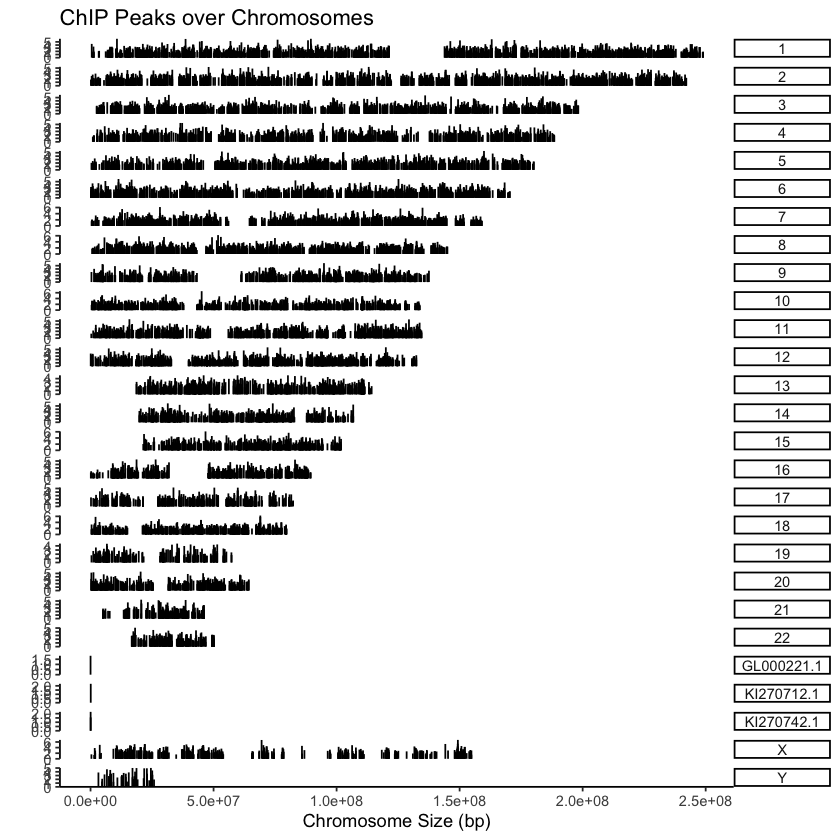

In [32]:
covplot(atac_hi_GR, weightCol = "V5") #nice but not so informative

Annotating peaks with information regarding their distance/overlaps with up or down regulated gene features

In [33]:
atac_hi_upreg <- annotatePeak(atac_hi_GR, 
                              tssRegion = c(-10000,1000), 
                              TxDb = txdb_up, 
                              annoDb = "org.Hs.eg.db", #adds extra info like ENTREZ ID and symbol
                              genomicAnnotationPriority = c("Promoter", 
                                                            "5UTR", 
                                                            "3UTR", 
                                                            "Exon", 
                                                            "Intron", 
                                                            "Downstream"))

>> preparing features information...		 2019-10-20 07:21:02 
>> identifying nearest features...		 2019-10-20 07:21:02 
>> calculating distance from peak to TSS...	 2019-10-20 07:21:02 
>> assigning genomic annotation...		 2019-10-20 07:21:02 
>> adding gene annotation...			 2019-10-20 07:21:06 
>> assigning chromosome lengths			 2019-10-20 07:21:06 
>> done...					 2019-10-20 07:21:06 


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000216.2, GL000221.1, KI270711.1, KI270712.1, KI270742.1
  - in 'y': MT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000216.2, GL000221.1, KI270711.1, KI270712.1, KI270742.1
  - in 'y': MT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000216.2, GL000221.1, KI270711.1, KI270712.1, KI270742.1
  - in 'y': MT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).

In [34]:
atac_hi_dwreg <- annotatePeak(atac_hi_GR, 
                              tssRegion = c(-10000,1000), 
                              TxDb = txdb_dw, 
                              annoDb = "org.Hs.eg.db", #adds extra info like ENTREZ ID and symbol
                              genomicAnnotationPriority = c("Promoter", 
                                                            "5UTR", 
                                                            "3UTR", 
                                                            "Exon",
                                                            "Intron", 
                                                            "Downstream"))

>> preparing features information...		 2019-10-20 07:21:06 
>> identifying nearest features...		 2019-10-20 07:21:07 
>> calculating distance from peak to TSS...	 2019-10-20 07:21:07 
>> assigning genomic annotation...		 2019-10-20 07:21:07 
>> adding gene annotation...			 2019-10-20 07:21:11 
>> assigning chromosome lengths			 2019-10-20 07:21:11 
>> done...					 2019-10-20 07:21:11 


'select()' returned 1:many mapping between keys and columns



In [35]:
atac_lo_upreg <- annotatePeak(atac_lo_GR, 
                              tssRegion = c(-10000,1000), 
                              TxDb = txdb_up, 
                              annoDb = "org.Hs.eg.db", #adds extra info like ENTREZ ID and symbol
                              genomicAnnotationPriority = c("Promoter", 
                                                            "5UTR", 
                                                            "3UTR", 
                                                            "Exon",
                                                            "Intron", 
                                                            "Downstream"))

>> preparing features information...		 2019-10-20 07:21:11 
>> identifying nearest features...		 2019-10-20 07:21:12 
>> calculating distance from peak to TSS...	 2019-10-20 07:21:12 
>> assigning genomic annotation...		 2019-10-20 07:21:12 
>> adding gene annotation...			 2019-10-20 07:21:15 
>> assigning chromosome lengths			 2019-10-20 07:21:16 
>> done...					 2019-10-20 07:21:16 


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000205.2, GL000219.1, KI270435.1, KI270442.1, KI270519.1, KI270581.1, KI270711.1, KI270713.1, KI270726.1, KI270727.1, KI270731.1, KI270744.1, KI270751.1
  - in 'y': MT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000205.2, GL000219.1, KI270435.1, KI270442.1, KI270519.1, KI270581.1, KI270711.1, KI270713.1, KI270726.1, KI270727.1, KI270731.1, KI270744.1, KI270751.1
  - in 'y': MT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': GL000205.2, GL0

In [36]:
atac_lo_dwreg <- annotatePeak(atac_lo_GR, 
                              tssRegion = c(-10000,1000), 
                              TxDb = txdb_dw, 
                              annoDb = "org.Hs.eg.db", #adds extra info like ENTREZ ID and symbol
                              genomicAnnotationPriority = c("Promoter", 
                                                            "5UTR", 
                                                            "3UTR", 
                                                            "Exon",
                                                            "Intron", 
                                                            "Downstream"))

>> preparing features information...		 2019-10-20 07:21:16 
>> identifying nearest features...		 2019-10-20 07:21:16 
>> calculating distance from peak to TSS...	 2019-10-20 07:21:16 
>> assigning genomic annotation...		 2019-10-20 07:21:16 
>> adding gene annotation...			 2019-10-20 07:21:20 
>> assigning chromosome lengths			 2019-10-20 07:21:20 
>> done...					 2019-10-20 07:21:20 


'select()' returned 1:many mapping between keys and columns



We can plot an overview of where the accessibility peaks land (distal/intergenic peaks have been purposefully left out but these simply appear as NAs)

pdf 
  2

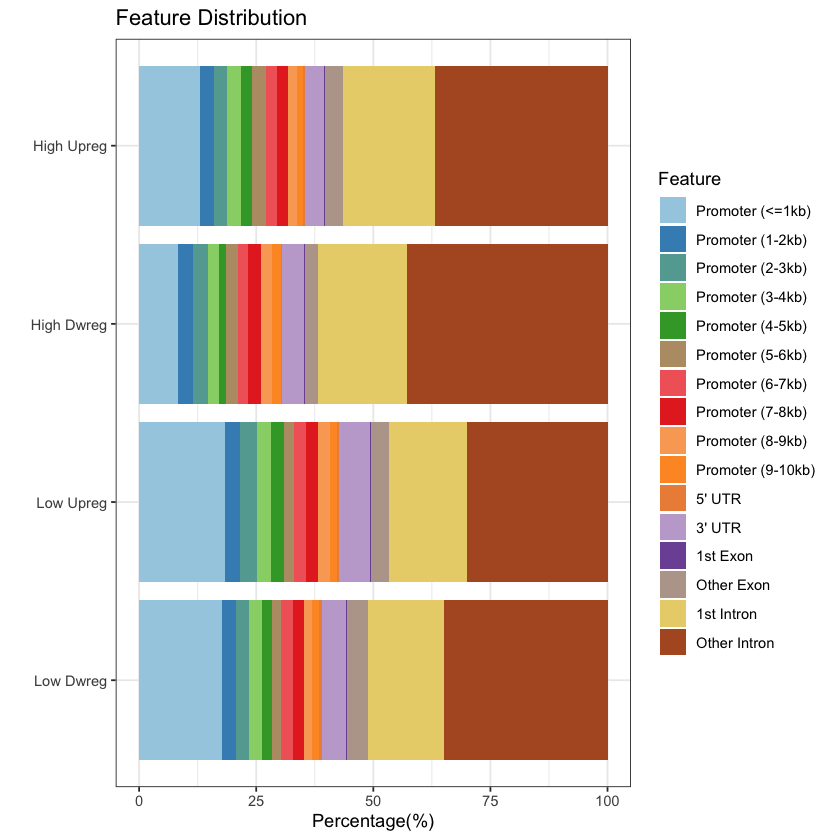

In [37]:
PeakAnnoList <- list("High Upreg"=atac_hi_upreg, 
                     "High Dwreg"=atac_hi_dwreg, 
                     "Low Upreg"=atac_lo_upreg, 
                     "Low Dwreg"=atac_lo_dwreg)
plotAnnoBar(PeakAnnoList)
#export as png
png("output/plot/atac_prox_bar.png", width = 1600, height = 1600)
plotAnnoBar(PeakAnnoList)
dev.off()

These steps allow us to build the coverage profiles in the "promoter" region which we initially defined as -10000 to +1000 from TSS/GeneStart

In [38]:
upreg_prom_locs <- getPromoters(TxDb = txdb_up, 
                                upstream = 10000, 
                                downstream = 1000)
dwreg_prom_locs <- getPromoters(TxDb = txdb_dw, 
                                upstream = 10000, 
                                downstream = 1000)
atac_hi_upreg_prom <- getTagMatrix(atac_hi_GR, 
                                   windows = upreg_prom_locs)
atac_hi_dwreg_prom <- getTagMatrix(atac_hi_GR, 
                                   windows = dwreg_prom_locs)
atac_lo_upreg_prom <- getTagMatrix(atac_lo_GR, 
                                   windows = upreg_prom_locs)
atac_lo_dwreg_prom <- getTagMatrix(atac_lo_GR, 
                                   windows = dwreg_prom_locs)
PromTagMList <- list("High Upreg"=atac_hi_upreg_prom, 
                     "High Dwreg"=atac_hi_dwreg_prom, 
                     "Low Upreg"=atac_lo_upreg_prom, 
                     "Low Dwreg"=atac_lo_dwreg_prom)

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': MT
  - in 'y': GL000216.2, GL000221.1, KI270711.1, KI270712.1, KI270742.1
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': MT
  - in 'y': GL000205.2, GL000219.1, KI270435.1, KI270442.1, KI270519.1, KI270581.1, KI270711.1, KI270713.1, KI270726.1, KI270727.1, KI270731.1, KI270744.1, KI270751.1
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


Heatmap views

pdf 
  2

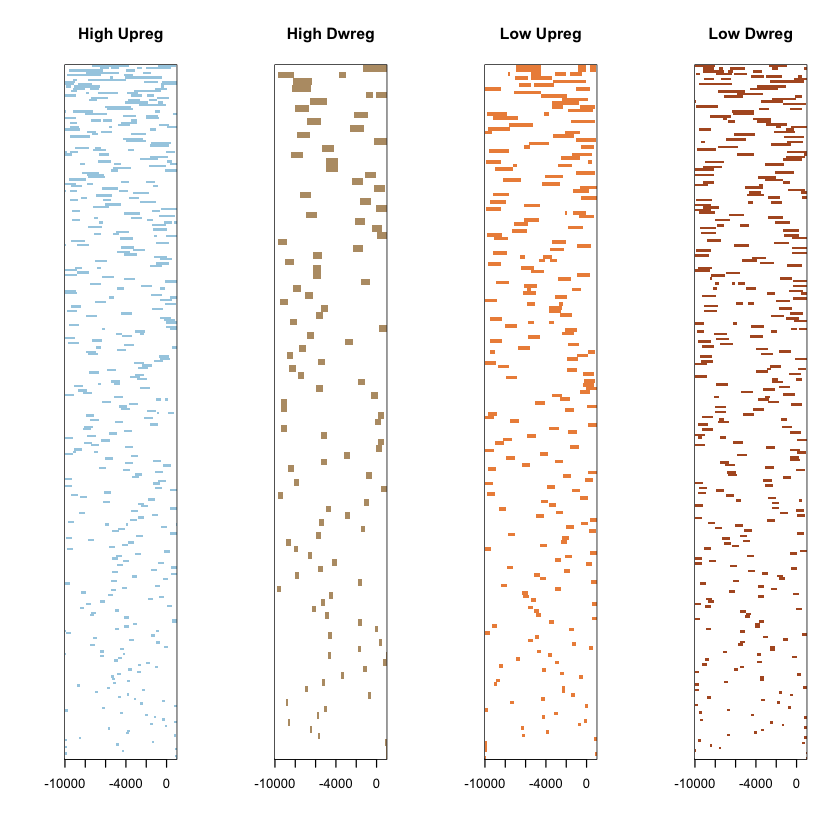

In [39]:
tagHeatmap(PromTagMList, 
           xlim=c(-10000, 1000), 
           color=NULL)
#export as png
png("output/plot/atac_prom_heatmap.png", width = 1600, height = 1600)
tagHeatmap(PromTagMList, xlim=c(-10000, 1000), color=NULL)
dev.off()

Next is the coverage plot, to identify hotspots visually

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



pdf 
  2

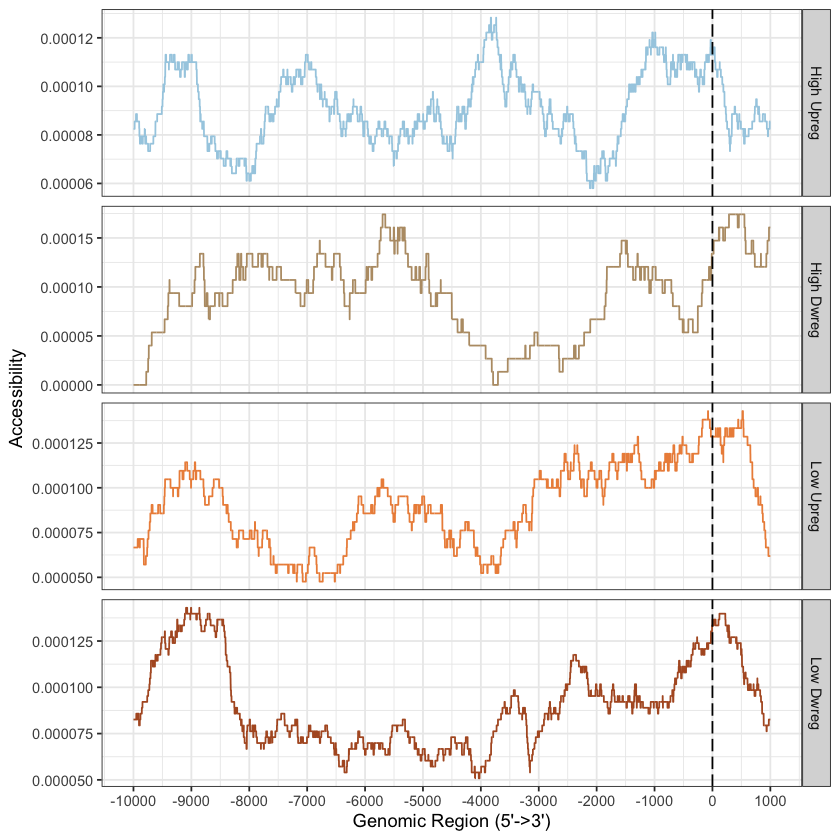

In [40]:
plotAvgProf(PromTagMList, 
            xlim = c(-10000,1000), 
            facet="row", 
            ylab = "Accessibility") + scale_x_continuous(breaks = round(seq(-10000, 1000, by = 1000),1))
#export as png
png("output/plot/atac_prom_graph.png", width = 1600, height = 1600)
plotAvgProf(PromTagMList, xlim = c(-10000,1000), facet="row", ylab = "Accessibility") + scale_x_continuous(breaks = round(seq(-10000, 1000, by = 1000),1))
dev.off()

based on this output we can select Regions of Interest:  

**High Access / Upregulated**
- Window 0: -2000 to 0  
- Window 1: -4250 to -3250  
- Window 2: -8000 to -4500
- Window 3: -9750 to -8500  

**High Access / Downregulated**
- Window 0: -2000 to 0  
- Window 1: -9500 to -4500  

**Low Access / Upregulated**
- Window 0: -3000 to 0  
- Window 1: -6000 to -4500  
- Window 2: -9750 to -8500

**Low Access / Downregulated**
- Window 0: -3000 to 0   
- Window 1: -9750 to -8250

In [41]:
atac_hi_upregDF <- as.data.frame(atac_hi_upreg)
atac_hi_dwregDF <- as.data.frame(atac_hi_dwreg)
atac_lo_upregDF <- as.data.frame(atac_lo_upreg)
atac_lo_dwregDF <- as.data.frame(atac_lo_dwreg)
write.table(atac_hi_upregDF, file="output/atac_hi_upreg.tsv", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)
write.table(atac_hi_dwregDF, file="output/atac_hi_dwreg.tsv", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)
write.table(atac_lo_upregDF, file="output/atac_lo_upreg.tsv", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)
write.table(atac_lo_dwregDF, file="output/atac_lo_dwreg.tsv", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Extracting the gene and coordinates that had hotspots in the "promoter" region

In [42]:
atac_hi_upreg_promDF <- atac_hi_upregDF[grep("Promoter", atac_hi_upregDF$annotation),]
atac_hi_dwreg_promDF <- atac_hi_dwregDF[grep("Promoter", atac_hi_dwregDF$annotation),]
atac_lo_upreg_promDF <- atac_lo_upregDF[grep("Promoter", atac_lo_upregDF$annotation),]
atac_lo_dwreg_promDF <- atac_lo_dwregDF[grep("Promoter", atac_lo_dwregDF$annotation),]
upregby_hiprom <- merge(rna_diffx, atac_hi_upreg_promDF, by.x = "name", by.y = "geneId", all = FALSE)
dwregby_hiprom <- merge(rna_diffx, atac_hi_dwreg_promDF, by.x = "name", by.y = "geneId", all = FALSE)
upregby_loprom <- merge(rna_diffx, atac_lo_upreg_promDF, by.x = "name", by.y = "geneId", all = FALSE)
dwregby_loprom <- merge(rna_diffx, atac_lo_dwreg_promDF, by.x = "name", by.y = "geneId", all = FALSE)
upregby_hiprom <- upregby_hiprom[!duplicated(upregby_hiprom$name),]
dwregby_hiprom <- dwregby_hiprom[!duplicated(dwregby_hiprom$name),]
upregby_loprom <- upregby_loprom[!duplicated(upregby_loprom$name),]
dwregby_loprom <- dwregby_loprom[!duplicated(dwregby_loprom$name),]
#back to bed6 format
upregby_hiprom <- upregby_hiprom[c(2:4,1,5,6)]
dwregby_hiprom <- dwregby_hiprom[c(2:4,1,5,6)]
upregby_loprom <- upregby_loprom[c(2:4,1,5,6)]
dwregby_loprom <- dwregby_loprom[c(2:4,1,5,6)]
dim(upregby_hiprom)
dim(dwregby_hiprom)
dim(upregby_loprom)
dim(dwregby_loprom)
#head(atac_hi_upreg_promDF,2)
#head(upregby_hiprom,2)
write.table(upregby_hiprom, file="output/upregby_hiprom.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)
write.table(dwregby_hiprom, file="output/dwregby_hiprom.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)
write.table(upregby_loprom, file="output/upregby_loprom.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)
write.table(dwregby_loprom, file="output/dwregby_loprom.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)

[1] 497   6

[1] 274   6

[1] 356   6

[1] 520   6